In [9]:
import numpy as np                                          
from mindquantum.core.circuit import Circuit                
from mindquantum.core.gates import H, RX, RY, RZ,X    
from mindquantum.core.parameterresolver import PRGenerator  
from mindquantum.simulator import Simulator
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split   
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.algorithm.nisq import IQPEncoding
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz     
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer,MQN2Layer                                              # 导入MQLayer
# 导入HardwareEfficientAnsatz
from mindquantum.core.gates import RY           
from mindquantum.core.circuit import UN
import torch
from torchvision import datasets, transforms# 导入量子门RY
from scipy.ndimage import zoom
import random
from data_processing import PCA_data_preprocessing

In [4]:
# 下载和加载 MNIST 数据集
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
X_train, X_test, y_train, y_test = PCA_data_preprocessing(mnist_dataset,8)

                                     Circuit Summary                                     
╭──────────────────────┬────────────────────────────────────────────────────────────────╮
│ Info                 │ value                                                          │
├──────────────────────┼────────────────────────────────────────────────────────────────┤
│ Number of qubit      │ 8                                                              │
├──────────────────────┼────────────────────────────────────────────────────────────────┤
│ Total number of gate │ 16                                                             │
│ Barrier              │ 0                                                              │
│ Noise Channel        │ 0                                                              │
│ Measurement          │ 0                                                              │
├──────────────────────┼────────────────────────────────────────────────────────────────┤
│ Parameter gate       │ 8                                                              │
│ 8 encoder parameters │ alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7 │
╰──────────────────────┴────────────────────────────────────────────────────────────────╯

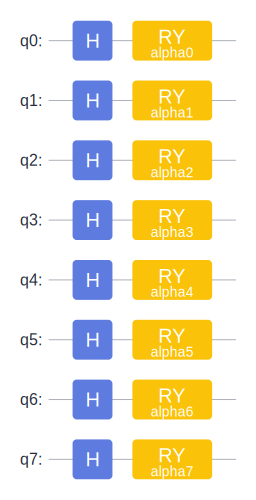

In [5]:
prg = PRGenerator('alpha')
nqbits = 8
encoder = Circuit()
encoder += UN(H, nqbits)                                  # H门作用在每1位量子比特
for i in range(nqbits):                                   # i = 0, 1, 2, 3
    encoder += RY(prg.new()).on(i)                 # RZ(alpha_i)门作用在第i位量子比特
encoder = encoder.no_grad()
encoder = encoder.as_encoder()# Encoder作为整个量子神经网络的第一层，不用对编码线路中的梯度求导数，因此加入no_grad()
encoder.summary()                                    # 总结Encoder
encoder.svg()

In [6]:
ansatz = HardwareEfficientAnsatz(8, single_rot_gate_seq=[RY], entangle_gate=X, depth=2).circuit   
ansatz.summary()                                    # 总结Ansatz

                                       Circuit Summary                                       
╭──────────────────────┬────────────────────────────────────────────────────────────────────╮
│ Info                 │ value                                                              │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Number of qubit      │ 8                                                                  │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Total number of gate │ 38                                                                 │
│ Barrier              │ 0                                                                  │
│ Noise Channel        │ 0                                                                  │
│ Measurement          │ 0                                                                  │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Parameter gate       │ 24                                                                 │
│ 24 ansatz parameters │ d0_n0_0, d0_n1_0, d0_n2_0, d0_n3_0, d0_n4_0, d0_n5_0, d0_n6_0,     │
│                      │ d0_n7_0, d1_n0_0, d1_n1_0...                                       │
╰──────────────────────┴────────────────────────────────────────────────────────────────────╯

In [10]:
from mindspore.nn import Adam, TrainOneStepCell    

In [11]:
ansatz = HardwareEfficientAnsatz(nqbits, single_rot_gate_seq=[RY], entangle_gate=X, depth=2).circuit     # 通过
hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0,1]]
ansatz = ansatz.as_ansatz()
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(2)                                                     # 设置生成随机数的种子
circuit = encoder+ ansatz.as_ansatz()         
sim = Simulator('mqvector', n_qubits=nqbits)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络

In [12]:
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.5)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
net = TrainOneStepCell(QuantumNet, opti,return_grad=True)

In [13]:
net.apply(

TrainOneStepCell<
  (network): MQLayer<
    (evolution): MQOps<8 qubits mqvector VQA Operator>
    >
  (optimizer): Adam<>
  (grad_reducer): Identity<>
  >

In [ ]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset
from torch.utils.data import DataLoader# 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集



loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # 通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.01)                  # 通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.1

model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             # 建立模型：将MindSpore Quantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络


train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(20) # 通过NumpySlicesDataset创建训练样本的数据集，shuffle=False表示不打乱数据，batch(5)表示训练集每批次样本点有5个
test_loader = NumpySlicesDataset({'features': X_test, 'labels': y_test},shuffle=False).batch(20)                   # 通过NumpySlicesDataset创建测试样本的数据集，batch(5)表示测试集每批次样本点有5个


class StepAcc(ms.Callback):                                                      # 定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def on_train_step_end(self, run_context):
        
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])
        # print(f'ACC = {self.acc[-1]}')


monitor = LossMonitor(20)                                                       # 监控训练中的损失，每16步打印一次损失值

acc = StepAcc(model, test_loader)                                               # 使用建立的模型和测试样本计算预测的准确率

model.train(20, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)# 将上述建立好的模型训练20次

In [ ]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

In [ ]:
from Test_tool import  Test_ansatz

In [ ]:
accz = Test_ansatz()


In [ ]:
accz[-1]